## Business Context

This analysis aims to identify high-potential customers for bank term-deposit marketing by building an interpretable propensity model. 
Beyond predicting subscription likelihood, the focus is on surfacing actionable customer segments that can support targeted outreach and resource prioritisation.

Rather than relying solely on static demographics, the model incorporates behavioural signals (RFM and contact history) to capture customers whose subscription propensity appears more responsive to marketing engagement, enabling more informed targeting decisions.



In [3]:
#step 1
import pandas as pd
import numpy as np

df = pd.read_csv(
    r"/Users/zhangnan/Documents/2025ba/foundation of ba/group/bank+marketing/bank/bank-full.csv",
    sep=";"
)


In [4]:
#2
y = df["y"].map({"no": 0, "yes": 1})


### RFM Feature Construction

To improve robustness and interpretability, raw behavioural metrics are transformed into ordinal RFM scores (1–5) using quantile-based binning. 
This reduces sensitivity to outliers and allows the model to focus on relative user standing rather than absolute magnitudes.


In [8]:
#Step 3：Define RFM features


def RFM_features(
    df,
    user_col,
    recency_col,
    frequency_col,
    monetary_col,
    n_bins=5
):
    """
    Build RFM features using quantile-based binning (pd.qcut).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with user-level data
    user_col : str
        User identifier column
    recency_col : str
        Recency metric (lower is better)
    frequency_col : str
        Frequency metric (higher is better)
    monetary_col : str
        Monetary / value metric (higher is better)
    n_bins : int
        Number of quantile bins (default = 5)

    Returns
    -------
    pd.DataFrame
        DataFrame with R, F, M scores (1–n_bins)
    """

    rfm = df[[user_col, recency_col, frequency_col, monetary_col]].copy()

    # Recency: smaller is better → reverse labels
    rfm["R_score"] = pd.qcut(
        rfm[recency_col],
        q=n_bins,
        labels=list(range(n_bins, 0, -1)),
        duplicates="drop"
    ).astype(int)

    # Frequency: larger is better
    rfm["F_score"] = pd.qcut(
        rfm[frequency_col],
        q=n_bins,
        labels=list(range(1, n_bins + 1)),
        duplicates="drop"
    ).astype(int)

    # Monetary: larger is better
    rfm["M_score"] = pd.qcut(
        rfm[monetary_col],
        q=n_bins,
        labels=list(range(1, n_bins + 1)),
        duplicates="drop"
    ).astype(int)

    return rfm[[user_col, "R_score", "F_score", "M_score"]]



### RFM Score Interpretation (Quantile-Based)

Each R, F, M score is constructed using quantile-based binning (`pd.qcut`) and ranges from 1 to 5.

- **Score = 1 (Low)**  
  Bottom 20% of users for this metric  
  Represents low engagement or low value

- **Score = 3 (Medium)**  
  Middle 60% of users  
  Represents average engagement or value

- **Score = 5 (High)**  
  Top 20% of users  
  Represents the most active or high-value users

For Recency, lower values indicate more recent activity, so scores are reversed accordingly.

These scores are not used as final business segments, but as **baseline value features** to capture user heterogeneity in downstream modeling (e.g. uplift modeling or targeting).


## Feature Strategy

Customer targeting decisions require more than demographic information alone. 
In this project, features are organised into three complementary layers:

- Demographic attributes: who the customer is
- Relationship-based RFM features: where the customer is in the lifecycle
- Financial and product constraints: whether the customer is eligible and suitable for the offer

This structure reflects how customer data is typically organised to support targeted marketing decisions in practice.



In [9]:
#Step 4：Define feature groups
demographic_cols = [
    "age", "job", "marital", "education"
]

rfm_cols = [
    "R_pdays", "R_never_contacted",
    "F_contacts",
    "M_balance_log", "M_negative_balance"
]

product_cols = [
    "loan", "housing", "default"
]

X = df[demographic_cols + rfm_cols + product_cols]


In [10]:
#Step 5：Categorical vs Numerical（prepare for SMOTENC）
cat_cols = [
    "job", "marital", "education",
    "loan", "housing", "default"
]

num_cols = [
    "age",
    "R_pdays", "R_never_contacted",
    "F_contacts",
    "M_balance_log", "M_negative_balance"
]


In [27]:
#Step 6: Train–Test Split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [28]:
#Step 7：One-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [30]:
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)


In [56]:
#Step 8：SMOTENC
from imblearn.over_sampling import SMOTENC


In [57]:
# get categorical feature indices after one-hot
cat_feature_indices = []

ohe = preprocessor.named_transformers_["cat"]
cat_feature_indices = list(
    range(ohe.transform(X_train[cat_cols]).shape[1])
)


In [58]:
smote = SMOTENC(
    categorical_features=cat_feature_indices,
    random_state=42
)


In [59]:
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)


In [60]:
#Step 9：Decision Tree
from sklearn.tree import DecisionTreeClassifier


In [61]:
tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=200,
    random_state=42
)


In [62]:
tree.fit(X_train_res, y_train_res)


DecisionTreeClassifier(max_depth=4, min_samples_leaf=200, random_state=42)

In [63]:
#Step 10：evaluation tree
from sklearn.metrics import roc_auc_score, average_precision_score


In [64]:
y_pred_proba = tree.predict_proba(X_test_enc)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

roc_auc, pr_auc


(0.6737293791255756, 0.24431202248446282)

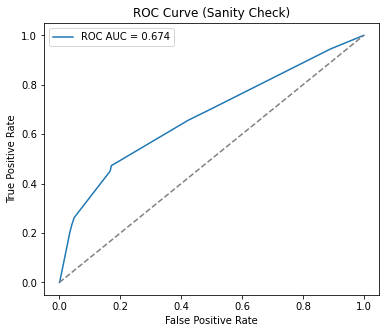

In [40]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Sanity Check)")
plt.legend()
plt.show()


### Model Discrimination (Sanity Check)

ROC curve is included as a basic validation of the model’s ability to distinguish subscribers from non-subscribers. 
The primary focus of this project remains interpretability and actionable segmentation rather than maximising predictive performance.


### Model Complexity Check 

Given the decision tree is primarily used for segmentation and ranking rather than pure prediction, 
we performed a lightweight complexity check to verify whether additional pruning would materially improve generalisation.


In [65]:

try:
    path = tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas
except ValueError:
    ccp_alphas = None


We inspected the cost-complexity pruning path to assess whether additional pruning was necessary. 
Given the intentionally constrained tree structure and data splits, cost-complexity pruning did not provide meaningful benefits, 
so the simpler configuration was retained.



In [66]:
###Step 11: Top-10 Gains
top_k = int(0.1 * len(y_test))
top_k_idx = y_pred_proba.argsort()[::-1][:top_k]
top10_gain = y_test.iloc[top_k_idx].sum() / y_test.sum()



In [67]:
top10_gain


0.2961562696912413

### Business-Oriented Evaluation: Top-10 Gains

The top 10% of users ranked by the model account for approximately 30% of total conversions, 
indicating a nearly 3× concentration compared to random targeting.


In [48]:
#Step 12：split rule summary
import pandas as pd
import numpy as np
from sklearn.tree import _tree


### Interpretable Segment Rules

To improve interpretability, we summarise the main decision rules learned by the tree and report 
their population coverage and observed conversion rates. 
The table below highlights high-conversion segments that are both actionable and sufficiently sized.


In [49]:
def extract_tree_rules(tree, X, y, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            recurse(tree_.children_left[node],
                    path + [f"{name} ≤ {threshold:.2f}"])
            recurse(tree_.children_right[node],
                    path + [f"{name} > {threshold:.2f}"])
        else:
            paths.append((node, path))

    recurse(0, [])

    records = []
    leaf_ids = tree.apply(X)

    for node_id, rule in paths:
        idx = leaf_ids == node_id
        samples = idx.sum()
        if samples == 0:
            continue

        pos_rate = y[idx].mean()
        proportion = samples / len(y)

        records.append({
            "samples": samples,
            "proportion": round(proportion, 3),
            "pos_rate": round(pos_rate, 3),
            "rule": " AND ".join(rule)
        })

    return pd.DataFrame(records).sort_values("pos_rate", ascending=False)


In [51]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)


In [52]:
rule_summary = extract_tree_rules(
    tree=tree,
    X=X_train_enc,
    y=y_train.values,
    feature_names=preprocessor.get_feature_names_out()
)

rule_summary


,samples,proportion,pos_rate,rule
11,39,0.001,0.538,cat__housing_yes > 0.50 AND num__R_pdays > 371.08 AND cat__marital_single > 0.50
6,115,0.004,0.443,cat__housing_yes ≤ 0.50 AND num__R_pdays > 8.04 AND cat__job_technician > 0.50 AND num__age > 42.06
10,76,0.002,0.421,cat__housing_yes > 0.50 AND num__R_pdays > 371.08 AND cat__marital_single ≤ 0.50
3,1607,0.051,0.414,cat__housing_yes ≤ 0.50 AND num__R_pdays > 8.04 AND cat__job_technician ≤ 0.50 AND cat__marital_divorced ≤ 0.50
2,254,0.008,0.366,cat__housing_yes ≤ 0.50 AND num__R_pdays ≤ 8.04 AND num__F_contacts > 2.00 AND num__age > 60.01
4,196,0.006,0.362,cat__housing_yes ≤ 0.50 AND num__R_pdays > 8.04 AND cat__job_technician ≤ 0.50 AND cat__marital_divorced > 0.50
5,200,0.006,0.315,cat__housing_yes ≤ 0.50 AND num__R_pdays > 8.04 AND cat__job_technician > 0.50 AND num__age ≤ 42.06
0,4090,0.129,0.162,cat__housing_yes ≤ 0.50 AND num__R_pdays ≤ 8.04 AND num__F_contacts ≤ 2.00 AND num__F_contacts ≤ 1.00
1,7560,0.239,0.096,cat__housing_yes ≤ 0.50 AND num__R_pdays ≤ 8.04 AND num__F_contacts > 2.00 AND num__age ≤ 60.01
8,2167,0.068,0.096,cat__housing_yes > 0.50 AND num__R_pdays ≤ 371.08 AND num__F_contacts ≤ 1.00 AND num__M_balance_log > 6.44


The rule summary highlights a clear trade-off between conversion rate and population size. 
While the highest-converting segments are relatively small, several medium-sized segments exhibit both elevated conversion rates and meaningful coverage, making them more actionable for targeted campaigns. 
In contrast, broader segments show substantially lower conversion rates, reinforcing the value of prioritising top-ranked users under budget constraints.


In [53]:
#Step 13：SHAP
import shap


In [54]:
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_train_res)


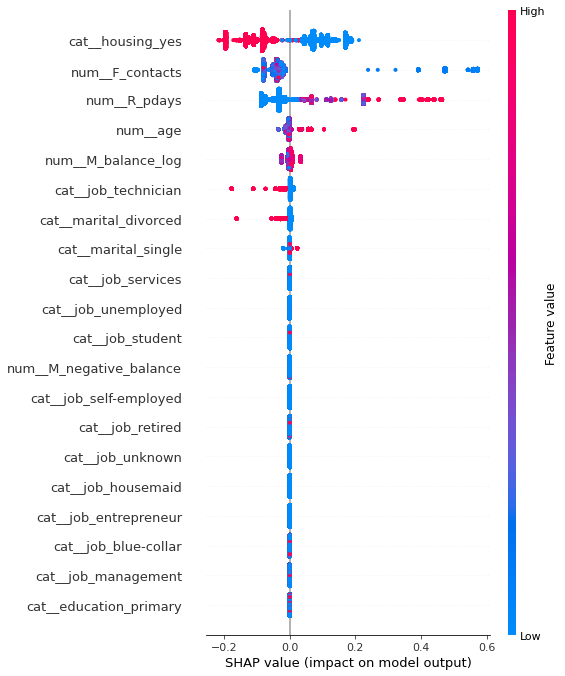

In [55]:
shap.summary_plot(
    shap_values[1],
    X_train_res,
    feature_names=preprocessor.get_feature_names_out()
)


### SHAP-Based Feature Attribution  

The SHAP summary provides a global validation of the decision rules identified earlier. 
Features driving higher conversion probability in the tree-based segmentation, such as prior contact recency and housing status, also exhibit consistent importance and directional effects at the global level.
